# Data Preprocessing + Modelling

In [1]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/data_after_preprocessing.csv')

Things to take note before using this modelling notebook

1. There are 2 approaches to using the text corpus  
    a. LDA: Hard to explain because clusters are not labelled but dimensionality has been reduced to 5 (based on grid)  
    b. TFIDF: 173 (based on vectorizer) tfidf float numbers exist per tweet. Easier explanability but high dimensionality)  
    
2. A new feature "day_after" has been added. Remember to include it in the modelling step if you wish to.  

3. Remember to do scaling on numerical features.

## Text Preprocessing

##### (3a) tf-count and topic model for tweets (Use LDA features by default to do modelling)

In [2]:
# Lemmatization
import nltk
nltk.download('wordnet')

from nltk.stem.wordnet import WordNetLemmatizer
df['tweet'] = df['tweet'].apply(lambda x:' '.join(WordNetLemmatizer().lemmatize(i) for i in x.split(' ')))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\flyxs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
df['tweet'].head()

0    service connected: covid-19 pandemic impacting...
1    i'm not gone lie ion like normal girl i like e...
2    content warning for billie’s documentary - str...
3    why am i helping my suicidal irl im literally ...
4    the polluter pay principle is a threat to this...
Name: tweet, dtype: object

In [4]:
# Remove punctuation
df['tweet'] = df['tweet'].str.replace('[^\w\s]','')
df['tweet'].head()

c:\users\flyxs\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


0    service connected covid19 pandemic impacting t...
1    im not gone lie ion like normal girl i like em...
2    content warning for billies documentary  stron...
3    why am i helping my suicidal irl im literally ...
4    the polluter pay principle is a threat to this...
Name: tweet, dtype: object

In [5]:
# Identifying words to be included in stop words
freq = pd.Series(' '.join(df['tweet']).split()).value_counts()[:10]
freq

suicidal    9243
to          7190
the         6492
i           6485
and         6098
a           6082
of          3828
is          3427
you         3151
that        2865
dtype: int64

#### In the word sampling steps in LDA, the word count is used as weights for the multinomial dist. Re-weighting the TF's by its IDF's would dispropotionally increase the chance of rare words being sampled, making them have a stronger influence in topic assignment. But rare words have equally low probabilities of showing up in all documents and topics, hence flattening out the topic distribution of each document. That is a similar reason why it is recommended to remove stop-words before running LDA. Hence we use CountVectorizer instead of TfidfVectorizer

In [6]:
# Run tf vectorizer

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV

# Adding a list of stop words to the wordlist
my_stop_words = text.ENGLISH_STOP_WORDS.union(['suicidal'])

count_vectorizer = CountVectorizer(min_df=0.01, stop_words=my_stop_words)

In [7]:
# Use vectors for LDA

x = count_vectorizer.fit_transform(df['tweet'])
k = 20 # try for 20 topics
lda_model = LatentDirichletAllocation(n_components=k, random_state=2021)
xtr = lda_model.fit_transform(x)

# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(x))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(x))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -304440.58450289094
Perplexity:  184.7018452199952
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'batch', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 20, 'n_jobs': None, 'perp_tol': 0.1, 'random_state': 2021, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


In [8]:
# Grid search because 20 topics might be too much

# Define Search Param
search_params = {'n_components': [5,8,11,14,17,20], 'learning_decay': [.7, .9], 'random_state': [2021]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, scoring=)

# Do the Grid Search
model.fit(x)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.7, 0.9],
                         'n_components': [5, 8, 11, 14, 17, 20],
                         'random_state': [2021]})

In [9]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(x))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 5, 'random_state': 2021}
Best Log Likelihood Score:  -60102.34735962497
Model Perplexity:  148.71668877139592


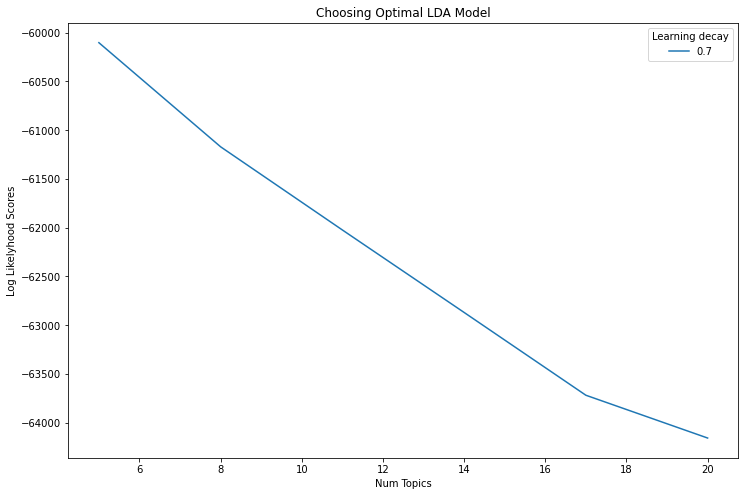

In [12]:
# View log likelihood scores
import matplotlib.pyplot as plt

# Get Log Likelyhoods from Grid Search Output
n_topics = [5,8,11,14,17,20]

log_likelyhoods_7 = []
log_likelyhoods_9 = []
for i in range (len(model.cv_results_['params'])):
    if model.cv_results_['params'][i]['learning_decay'] == 0.7:
        log_likelyhoods_7.append(round(model.cv_results_['mean_test_score'][i]))

# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelihood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [11]:
# So xtr will be new features to replace 'tweet'
xtr = best_lda_model.fit_transform(x)

data_x = pd.DataFrame(xtr).add_prefix('topic_')

#### (3b) Caution! Do not run the next cell if you are using LDA. If we do not want to use LDA, just use the word counts instead as shown. However, it is more advisable to use tf-idf instead of tf

In [18]:
# Run this if we do not want to run LDA
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer

# Adding a list of stop words to the wordlist
my_stop_words = text.ENGLISH_STOP_WORDS.union(['suicidal'])


Tfidf_Vectorizer = TfidfVectorizer(min_df=0.01, stop_words=my_stop_words)

x_tfidf = Tfidf_Vectorizer.fit_transform(df['tweet'])
n_tfidf,m_tfidf = x_tfidf.shape

print(n_tfidf, m_tfidf)

11439 173
